# Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы.

Стоимость туров:

Таиланд — 100000 рублей;
Турция — 60000 рублей;
Мальдивы — 200000 рублей;
Санкт-Петербург — 10000 рублей;
Камчатка — 150000 рублей.
Проверьте, какая из страниц приносит больше покупок.
## Задачи: проанализировать результаты А/B теста.
### Рассчитать кумулятивные метрики:
постройте график конверсии в группах по дням;
постройте график среднего чека в группах по дням;
постройте график кумулятивных метрик по конверсии и по среднему чеку;
сделайте выводы.
### Провести статистическую проверку гипотез:
равенстве конверсии;
равенстве выручки;
равенстве средних чеков по дням.

In [3]:
import pandas as pd
import scipy.stats as st 
import seaborn as sns
import matplotlib.pyplot as plt
import math as mth

# получаем файл
df = pd.read_csv('C:/Users/admin/Desktop/skillfactory/IDE/ab_data.csv', index_col = False)
df = df.drop(columns = 'Unnamed: 0')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


### Оценим, за какой период нам предоставлены данные

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.describe(datetime_is_numeric=True)

,user_id,date,purchase,price
count,294478.000000,294478,294478.000000,294478.000000
mean,787974.124733,2021-01-13 01:39:48.011328,0.119659,10154.782361
min,630000.000000,2021-01-02 00:00:00,0.000000,0.000000
25%,709032.250000,2021-01-08 00:00:00,0.000000,0.000000
50%,787933.500000,2021-01-13 00:00:00,0.000000,0.000000
75%,866911.750000,2021-01-19 00:00:00,0.000000,0.000000
max,945999.000000,2021-01-24 00:00:00,1.000000,200000.000000
std,91210.823776,NaN,0.324563,35153.824872


Делим датафрейм по группам

In [5]:
dfa = df[df['group']=='A']
dfb = df[df['group']=='B']
# смотрим количество посещений в группах и процент отклонения 
print("Пользователей в группе А - {}; пользователей в группе В - {}"\
      .format(dfa.user_id.count(), dfb.user_id.count()) )
print("Процент отколнения равен {}%. Распределение сработало корректно. Продолжаем тест, так как разница не превышает 1%"\
      .format(round((dfa.user_id.count()-dfb.user_id.count())*100/dfb.user_id.count(), 3)))

Пользователей в группе А - 147202; пользователей в группе В - 147276
Процент отколнения равен -0.05%. Распределение сработало корректно. Продолжаем тест, так как разница не превышает 1%


Проверим наличие пользователей, попавших в обе тестовые группы:

In [6]:
set_a=set(dfa.user_id)
set_b=set(dfb.user_id)
print(len(set_a) - len(set_a.difference(set_b)), 'пользователей попали в обе группы')

1895 пользователей попали в обе группы


In [7]:
bb = set_b.copy()
aa = set_a.copy()
a = set_a.difference(bb) # группа А
b = bb.difference(aa) # группа B
dfa = dfa[dfa.user_id.isin(a)] # отфильтруем и актуальзируем датафреймы
dfb = dfb[dfb.user_id.isin(b)]
display(dfa.info())
display(dfb.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145307 entries, 0 to 294476
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   145307 non-null  int64         
 1   date      145307 non-null  datetime64[ns]
 2   group     145307 non-null  object        
 3   purchase  145307 non-null  int64         
 4   price     145307 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 6.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145381 entries, 2 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   145381 non-null  int64         
 1   date      145381 non-null  datetime64[ns]
 2   group     145381 non-null  object        
 3   purchase  145381 non-null  int64         
 4   price     145381 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 6.7+ MB


None

In [8]:
df_full=pd.concat([dfa, dfb], ignore_index=True, axis=0) 
df_full_g = df_full.groupby(['group'], as_index=False).agg({'user_id' : 'count', 'purchase': 'sum', 'price': 'sum'})
df_full_g['avg_price'] = round((df_full_g['price'] / df_full_g['purchase']),2) # средний чек
df_full_g['conversion, %'] = round((df_full_g['purchase']*100 / df_full_g['user_id']),2) # конверсия в покупку
display(df_full_g)

,group,user_id,purchase,price,avg_price,"conversion, %"
0,A,145307,17487,1417780000,81076.23,12.03
1,B,145381,17290,1533010000,88664.55,11.89


Несмотря на то что в группе B было больше посетителей, (относительная) конверсия в группе B меньше на 1.16%. За счёт меньшей конверсии в группе B было меньше покупок, однако выручка группы B больше выручки группы A на 115230000 единиц, или 7.5%. Большая выручка в группе B складывается за счёт того, что средний чек группы B выше среднего чека группы A.

### Построим гистограммы по выручке для обеих групп

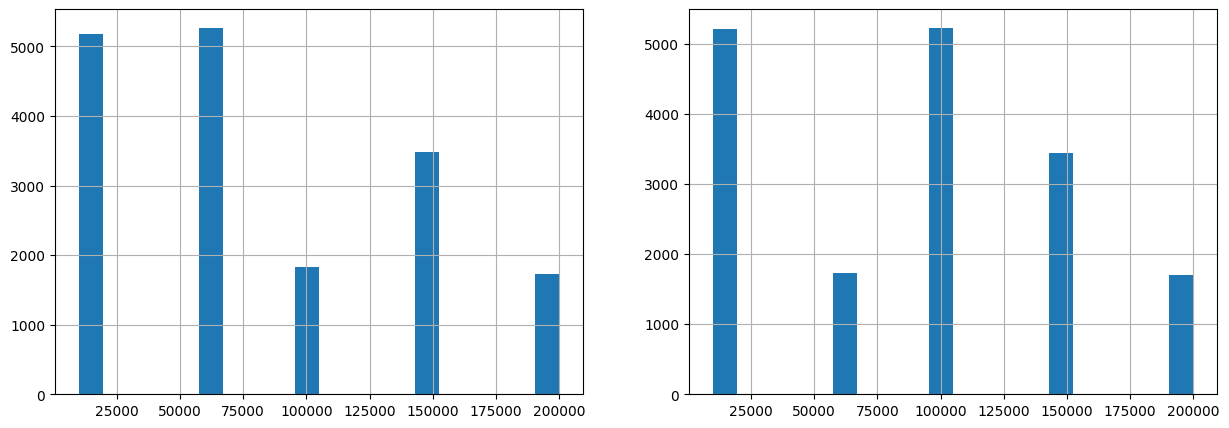

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
axes[0].hist(df_full[(df_full['group'] == 'A')&(df_full['price']>0)].price, bins = 20, label='Group A')
axes[1].hist(df_full[(df_full['group'] == 'B')&(df_full['price']>0)].price, bins = 20, label='Group B')
axes[0].grid(True) 
axes[1].grid(True) 

Участники группы A чаще покупают туры за 60000 рублей, при этом реже покупают туры за 100000 рублей. В остальном покупательская способность обеих групп похожа.

### Создадим кумулятивную таблицу

In [10]:
def cummulative_table(data): # В переменную data будем передавать название переменной датафейма
    df_cumm = [] # Создаём пустой список
    for i in data['date'].values: # Запускаем цикл по каждому отдельному значению даты
        out = data[data['date'] <= i].groupby('group')\
               .agg({'date':'max', 'user_id':'sum', 'purchase':'sum', 'price': 'sum'})
        df_cumm.append(out) # Полученный срез добавляем в созданный ранее список
    return pd.concat(df_cumm).reset_index() # Объединяем списки и возвращаем результат
total_df = df_full.groupby(['date', 'group'], as_index=False).agg({'user_id' : 'count', 'purchase': 'sum', 'price': 'sum'})
cumm_df = cummulative_table(total_df).drop_duplicates()
cumm_df.head()

,group,date,user_id,purchase,price
0,A,2021-01-02,2854,359,29410000
1,B,2021-01-02,2861,345,29660000
4,A,2021-01-03,9450,1107,91410000
5,B,2021-01-03,9480,1099,95620000
8,A,2021-01-04,16016,1906,155660000


In [11]:
cumm_df['total_conv'] =  round((cumm_df['purchase']*100 / cumm_df['user_id']),2)
cumm_df['avg_price'] =  round((cumm_df['price'] / cumm_df['purchase']),2)
cumm_a = cumm_df[cumm_df['group'] == 'A'] # таблицы кум. метрик по группам
cumm_b = cumm_df[cumm_df['group'] == 'B']
display(cumm_a.head())
display(cumm_b.head())

,group,date,user_id,purchase,price,total_conv,avg_price
0,A,2021-01-02,2854,359,29410000,12.58,81922.01
4,A,2021-01-03,9450,1107,91410000,11.71,82574.53
8,A,2021-01-04,16016,1906,155660000,11.90,81668.42
12,A,2021-01-05,22449,2696,220210000,12.01,81680.27
16,A,2021-01-06,29055,3460,283620000,11.91,81971.10


,group,date,user_id,purchase,price,total_conv,avg_price
1,B,2021-01-02,2861,345,29660000,12.06,85971.01
5,B,2021-01-03,9480,1099,95620000,11.59,87006.37
9,B,2021-01-04,16016,1863,163650000,11.63,87842.19
13,B,2021-01-05,22527,2612,227200000,11.59,86983.15
17,B,2021-01-06,29278,3450,302220000,11.78,87600.00


### Построим график кумулятивных среднего чека и конверсии для обеих групп по дням

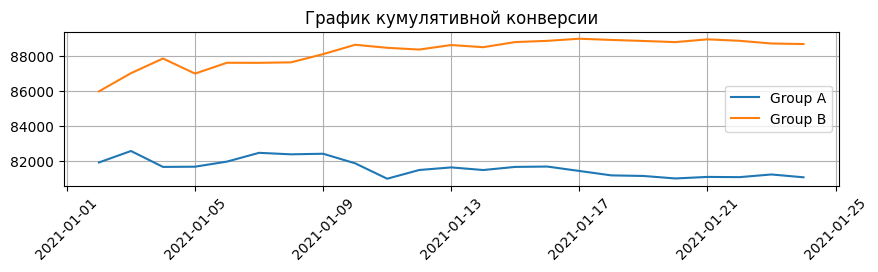

In [12]:
# график кумулятивного среднего чека
plt.figure(figsize=(10,2))
plt.plot(cumm_a['date'], cumm_a['avg_price'], label='Group A')
plt.plot(cumm_b['date'], cumm_b['avg_price'], label='Group B')
plt.title('График кумулятивной конверсии')
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
plt.show()

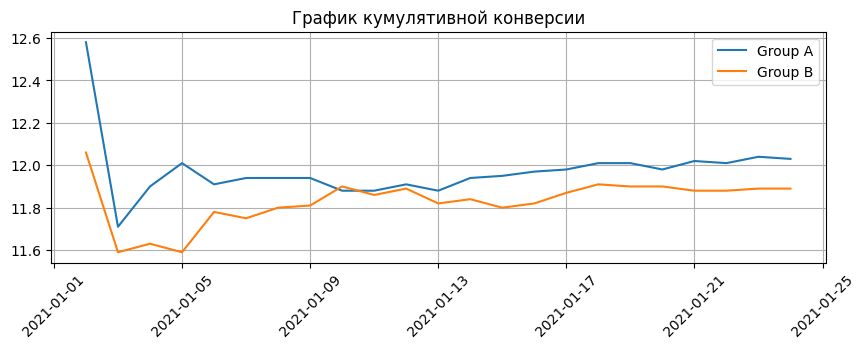

In [13]:
# График кумулятивной конверсии
plt.figure(figsize=(10,3))
plt.plot(cumm_a['date'], cumm_a['total_conv'], label='Group A')
plt.plot(cumm_b['date'], cumm_b['total_conv'], label='Group B')
plt.title('График кумулятивной конверсии')
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
plt.show()

Изначально конверсия группы B была ниже конверсии группы А, однако она показывала стабильный рост, и примерно 10 января конверсия группы B стала выше конверсии группы А. После чего конверсия группы B зафиксировалась примерно на этом уровне (с колебаниями). В то время как конверсия группы А начала постепенно расти. В результате конверсия группы А стабильно выше группы B. Но средний чек группы B выше среднего чека группы А.

### Проверим распределение показателей конверсии в группах:

In [14]:
total_df['total_conv'] = (total_df['purchase'] / total_df['user_id'])
total_df['avg_price'] =  (total_df['price'] / total_df['purchase'])
total_df.head()

,date,group,user_id,purchase,price,total_conv,avg_price
0,2021-01-02,A,2854,359,29410000,0.125788,81922.005571
1,2021-01-02,B,2861,345,29660000,0.120587,85971.014493
2,2021-01-03,A,6596,748,62000000,0.113402,82887.700535
3,2021-01-03,B,6619,754,65960000,0.113914,87480.106101
4,2021-01-04,A,6566,799,64250000,0.121687,80413.016270


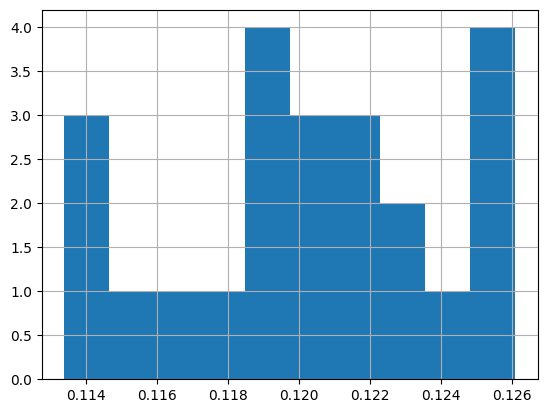

In [28]:
total_df['total_conv'][total_df['group'] == 'A'].hist();

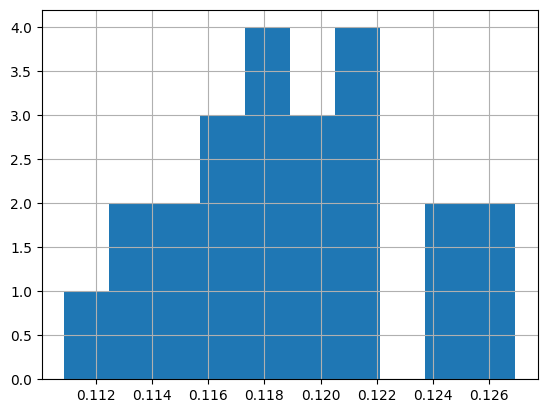

In [16]:
total_df['total_conv'][total_df['group'] == 'B'].hist();

Распределение похоже на нормальное, проведем Z-тест для долей

### Z-тест 

уровень статистической значимости 5% (0.05)

In [17]:
x1=total_df[total_df['group'] == 'A']['purchase'].sum()
x2=total_df[total_df['group'] == 'B']['purchase'].sum()
n2=total_df[total_df['group'] == 'B']['user_id'].sum()
n1=total_df[total_df['group'] == 'A']['user_id'].sum()
 # нужно как отношение суммы количества покупок к сумме пользователей 
# (и по группам, и по всей выборке) (отредактировано) 

# считаем пропорции
p1 = x1/n1
p2 = x2/n2
p = (x1 + x2) / (n1 + n2)
diff = p1 - p2
#Рассчитаем Z-статистику:

z = diff / mth.sqrt(p * (1 - p) * (1/n1 + 1/n2))
#Теперь из полученной Z-статистики рассчитаем p-value при нормальном стандартном распределении.

#Зададим нормальное стандартное распределение со средним, равным нулю, и стандартным отклонением, равным единице:

distr = st.norm(0, 1)
#Рассчитаем p-value:

p_val = (1 - distr.cdf(abs(z)))*2 
print(p_val)
print(p_val<.05)

0.23940749849829834
False


P-value больше принятого уровня значимости (5%), следовательно, статистически значимая разница между конверсиями отсутствует.

### Проверим гипотезу о равенстве выручки:

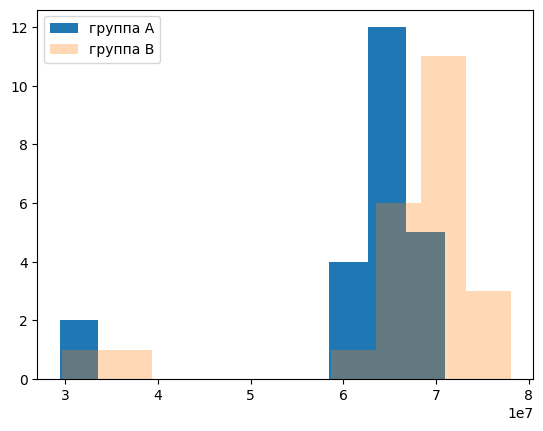

In [18]:
plt.hist(total_df[(total_df['group'] == 'A') & (total_df['purchase'] > 0)]['price'], label='группа A')
plt.hist(total_df[(total_df['group'] == 'B') & (total_df['purchase'] > 0)]['price'], label='группа B', alpha=0.3)
plt.legend() 
plt.show() 

In [19]:
st.shapiro(total_df[total_df['group'] == 'A'].price) 
# проверяем на норяем на нормальность критерием Шапиро-Уилка

ShapiroResult(statistic=0.6358132362365723, pvalue=2.2869323856866686e-06)

In [20]:
st.shapiro(total_df[total_df['group'] == 'B'].price)

ShapiroResult(statistic=0.6256370544433594, pvalue=1.7464255961385788e-06)

Распределение не нормальное, используем Тест Манна-Уитни

In [21]:
x = st.mannwhitneyu(total_df[total_df['group'] == 'A']['price'], total_df[total_df['group'] == 'B']['price'], alternative='two-sided')
display(x)

MannwhitneyuResult(statistic=99.0, pvalue=0.00028893174193897724)

pvalue < 0,05 - следовательно выручка не равна(стоимость заказов)

### Проверим различия средних чеков по дням:

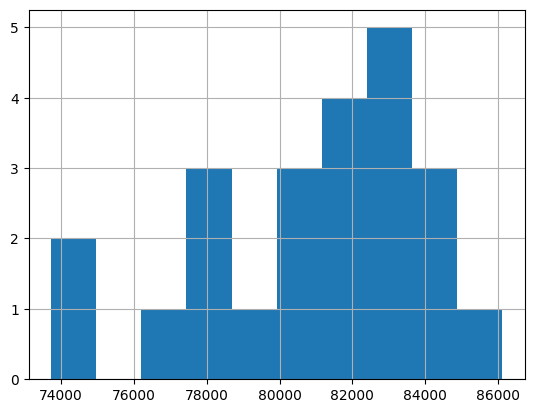

In [22]:
total_df[total_df['group'] == 'A'].avg_price.hist();

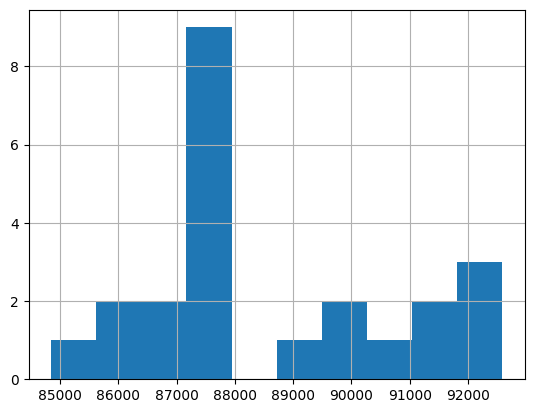

In [23]:
total_df[total_df['group'] == 'B'].avg_price.hist();

Проверим на нормальность:

In [24]:
st.shapiro(total_df[total_df['group'] == 'A'].avg_price)

ShapiroResult(statistic=0.9469833970069885, pvalue=0.25307759642601013)

In [25]:
st.shapiro(total_df[total_df['group'] == 'B'].avg_price)

ShapiroResult(statistic=0.9269078373908997, pvalue=0.09378302097320557)

pvalue больше 5% - распределения нормальные, значит проводим Т-тест

In [26]:
results = st.ttest_ind(total_df[total_df['group'] == 'A'].avg_price, total_df[total_df['group'] == 'B'].avg_price, equal_var = True)
display(results)

Ttest_indResult(statistic=-9.609061044565284, pvalue=2.2523589349617907e-12)

### Несмотря на то что конверсия группы B ниже, статистической значимости в конверсии не достигнуто, соответственно, считать конверсии разными оснований нет. Зато средний чек группы B значительно выше среднего чека группы A. Статистическая значимость достигнута. Вариант сайта B приносит значимо больше выручки, чем вариант сайта A. Рекомендуем признать, что вариант B лучше, чем вариант A!